<a href="https://colab.research.google.com/github/Lucs1590/USeS-BPCA/blob/main/notebooks/u_net_bpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net-like with Oxford-IIIT Pet Dataset

## Imports

In [20]:
import os
import time

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from keras.callbacks import (EarlyStopping, ModelCheckpoint, CSVLogger)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [21]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'content' in os.getcwd():
    COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    RESOURCES_DIR = f'{os.path.join(os.getcwd(), os.pardir)}/resources/'
else:
    RESOURCES_DIR = f'{(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))}/resources/'

np.random.seed(77)
tf.random.set_seed(77)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Constant Variables

In [22]:
RESOURCES_DIR = RESOURCES_DIR.replace('..', '').replace('//', '/')
None if os.path.isdir(RESOURCES_DIR) else os.mkdir(RESOURCES_DIR)
MODEL_NAME = 'raw_unet'

BATCH_SIZE = 64
BUFFER_SIZE = 1000
HEIGHT, WIDTH = 256, 256
NUM_CLASSES = 3  # background, foreground, boundary
NUM_EPOCHS = 20
VAL_SUBSPLITS = 5


In [23]:
RESOURCES_DIR

'/content/resources/'

## Dataset
Download and applying transformations to the dataset.


In [42]:
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    with_info=True,
    shuffle_files=True,
    data_dir='/content/gdrive/MyDrive/Projetos/' if COLAB else '/home/brito/tensorflow_datasets/',
)

print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/content/gdrive/MyDrive/Projetos/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,

In [25]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

TEST_LENTH = info.splits["test"].num_examples - 669
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS


In [26]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(
        input_image,
        (HEIGHT, WIDTH),
        method="nearest"
    )
    input_mask = tf.image.resize(input_mask, (HEIGHT, WIDTH), method="nearest")

    return input_image, input_mask


In [27]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


In [28]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


In [29]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [30]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [31]:
train_dataset = dataset["train"].map(
    load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(
    load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

print(train_dataset)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>


In [32]:
train_batches = train_dataset.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)


In [33]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


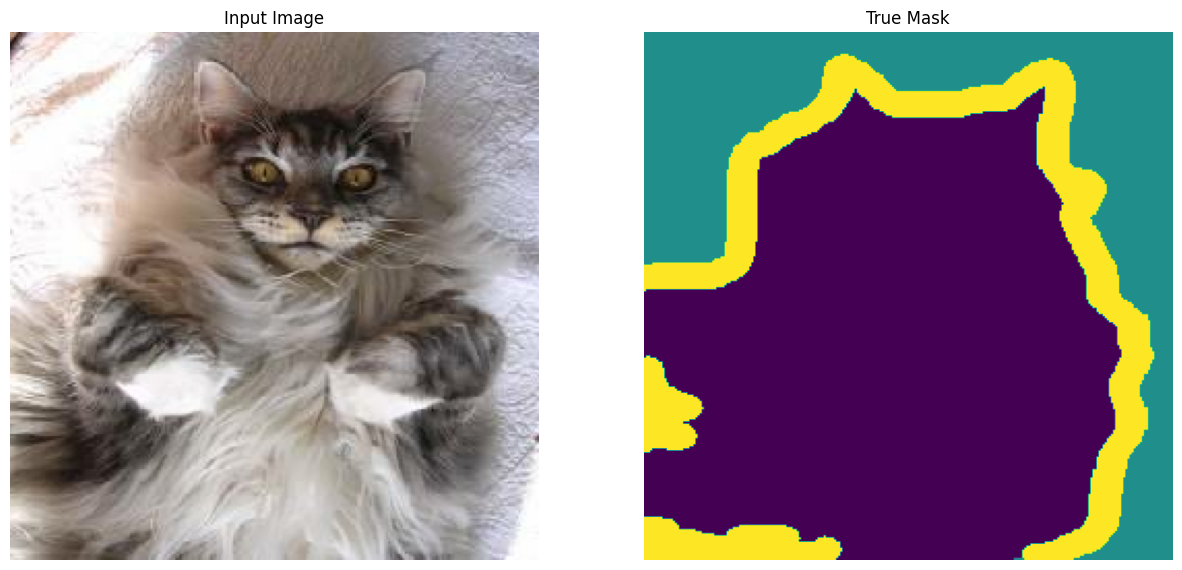

In [34]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])


## U-net-like architecture

In [35]:
def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [36]:
model = get_unet_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)


In [37]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [38]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 activation_1 True
5 separable_conv2d True
6 batch_normalization_1 True
7 activation_2 True
8 separable_conv2d_1 True
9 batch_normalization_2 True
10 max_pooling2d True
11 conv2d_1 True
12 add True
13 activation_3 True
14 separable_conv2d_2 True
15 batch_normalization_3 True
16 activation_4 True
17 separable_conv2d_3 True
18 batch_normalization_4 True
19 max_pooling2d_1 True
20 conv2d_2 True
21 add_1 True
22 activation_5 True
23 separable_conv2d_4 True
24 batch_normalization_5 True
25 activation_6 True
26 separable_conv2d_5 True
27 batch_normalization_6 True
28 max_pooling2d_2 True
29 conv2d_3 True
30 add_2 True
31 activation_7 True
32 conv2d_transpose True
33 batch_normalization_7 True
34 activation_8 True
35 conv2d_transpose_1 True
36 batch_normalization_8 True
37 up_sampling2d_1 True
38 up_sampling2d True
39 conv2d_4 True
40 add_3 True
41 activation_9 True
42 conv2d_transpose_2 True
43 batch_normalization_9 T

In [39]:
# plot_model(
#     model,
#     to_file=f'{RESOURCES_DIR}model.png',
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB'
# )


## Training & Testing

In [40]:
optimizer = Adam(learning_rate=1e-5)
# optimizer = SGD(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [41]:
model_checkpointer = ModelCheckpoint(
    f'{RESOURCES_DIR}{MODEL_NAME}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)
store_history = CSVLogger(f'{RESOURCES_DIR}{MODEL_NAME}.csv', append=True)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    mode='auto',
    verbose=1,
    patience=100
)

start_time = time.perf_counter()
with tf.device('/gpu:0'):
    model_history = model.fit(
        train_batches,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        validation_data=validation_batches,
        verbose=1,

        callbacks=[
            model_checkpointer,
            store_history
            # early_stopping
        ]
    )
end_time = time.perf_counter()


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.9630 - accuracy: 0.5392
Epoch 1: val_accuracy improved from -inf to 0.56828, saving model to /content/resources/raw_unet.h5
57/57 [==============================] - 79s 824ms/step - loss: 1.9630 - accuracy: 0.5392 - val_loss: 1.3059 - val_accuracy: 0.5683
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.3501 - accuracy: 0.6131
Epoch 2: val_accuracy improved from 0.56828 to 0.56904, saving model to /content/resources/raw_unet.h5
57/57 [==============================] - 52s 799ms/step - loss: 1.3501 - accuracy: 0.6131 - val_loss: 1.9633 - val_accuracy: 0.5690
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.6369

KeyboardInterrupt: ignored

In [ ]:
print(f'Time to train: {str("{0:.2f}".format((end_time - start_time) / 60))}')


In [ ]:
model.save(f'{RESOURCES_DIR}{MODEL_NAME}_last_epoch.h5')
model_json = model.to_json()
with open(f'{RESOURCES_DIR}{MODEL_NAME}.json', "w") as json_file:
    json_file.write(model_json)


In [ ]:
loss, accuracy = model.evaluate(test_batches, verbose=1)
print("Loss:", loss)
print("Accuracy: %.2f%%" % (accuracy * 100))


In [ ]:
if isinstance(history, pd.DataFrame):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['train', 'test'])
    plt.title('loss')
    plt.legend(["Loss", "Validation Loss"])
    plt.savefig("loss.png", dpi=300, format="png")
    plt.figure()
    plt.plot(history["accuracy"])
    plt.plot(history['val_accuracy'])
    plt.legend(['train', 'test'])
    plt.title('accuracy')

else:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'test'])
    plt.title('loss')
    plt.legend(["Loss", "Validation Loss"])
    plt.savefig("loss.png", dpi=300, format="png")
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'test'])
    plt.title('accuracy')

plt.legend(["Accuracy", "Validation Accuracy"])
plt.savefig("accuracy.png", dpi=300, format="png")


## Prediction

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
show_predictions(test_batches.skip(5), 3)
